## FRESCO: Spatial-Temporal Correspondence for Zero-Shot Video Translation (CVPR 24)


### 0) preperation

- download the full repository
- prepare environment based on `requirements.txt`
- run `python install.py` to download the supporting models
  - check `./model/gmflow_sintel-0c07dcb3.pth` and `epoch_resnet.pth` are downloaded
  - check `./src/ControlNet/annotator/ckpts/ControlNetHED.pth` is downloaded
  - check `./src/ControlNet/annotator/ckpts/dpt_hybrid-midas-501f0c75.pt` is downloaded
  - check `./src/ebsynth/deps/ebsynth/bin/ebsynth (or ebsynth.exe)` is downloaded

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "6"

# uncomment the next line to use huggingface model in China
#os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import cv2
import io
import gc
import yaml
import argparse
import torch
import torchvision
import diffusers
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDPMScheduler, ControlNetModel

from src.utils import *
from src.keyframe_selection import get_keyframe_ind
from src.diffusion_hacked import apply_FRESCO_attn, apply_FRESCO_opt, disable_FRESCO_opt
from src.diffusion_hacked import get_flow_and_interframe_paras, get_intraframe_paras
from src.pipe_FRESCO import inference

/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1) define supporting functions: load models

In [2]:
def get_models(config):
    print('\n' + '=' * 100)
    print('creating models...')
    import sys
    sys.path.append("./src/ebsynth/deps/gmflow/")
    sys.path.append("./src/EGNet/")
    sys.path.append("./src/ControlNet/")
    
    from gmflow.gmflow import GMFlow
    from model import build_model
    from annotator.hed import HEDdetector
    from annotator.canny import CannyDetector
    from annotator.midas import MidasDetector

    # optical flow
    flow_model = GMFlow(feature_channels=128,
                   num_scales=1,
                   upsample_factor=8,
                   num_head=1,
                   attention_type='swin',
                   ffn_dim_expansion=4,
                   num_transformer_layers=6,
                   ).to('cuda')
    
    checkpoint = torch.load(config['gmflow_path'], map_location=lambda storage, loc: storage)
    weights = checkpoint['model'] if 'model' in checkpoint else checkpoint
    flow_model.load_state_dict(weights, strict=False)
    flow_model.eval() 
    print('create optical flow estimation model successfully!')
    
    # saliency detection
    sod_model = build_model('resnet')
    sod_model.load_state_dict(torch.load(config['sod_path']))
    sod_model.to("cuda").eval()
    print('create saliency detection model successfully!')
    
    # controlnet
    if config['controlnet_type'] not in ['hed', 'depth', 'canny']:
        print('unsupported control type, set to hed')
        config['controlnet_type'] = 'hed'
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-"+config['controlnet_type'], 
                                                 torch_dtype=torch.float16)
    controlnet.to("cuda") 
    if config['controlnet_type'] == 'depth':
        detector = MidasDetector()
    elif config['controlnet_type'] == 'canny':
        detector = CannyDetector()
    else:
        detector = HEDdetector()
    print('create controlnet model-' + config['controlnet_type'] + ' successfully!')
    
    # diffusion model
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
    pipe = StableDiffusionPipeline.from_pretrained(config['sd_path'], vae=vae, torch_dtype=torch.float16)
    pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
    pipe.to("cuda")
    pipe.scheduler.set_timesteps(config['num_inference_steps'], device=pipe._execution_device)
    
    if config['use_freeu']:
        from src.free_lunch_utils import apply_freeu
        apply_freeu(pipe, b1=1.2, b2=1.5, s1=1.0, s2=1.0)

    frescoProc = apply_FRESCO_attn(pipe)
    frescoProc.controller.disable_controller()
    apply_FRESCO_opt(pipe)
    print('create diffusion model ' + config['sd_path'] + ' successfully!')
    
    for param in flow_model.parameters():
        param.requires_grad = False    
    for param in sod_model.parameters():
        param.requires_grad = False
    for param in controlnet.parameters():
        param.requires_grad = False
    for param in pipe.unet.parameters():
        param.requires_grad = False
    
    return pipe, frescoProc, controlnet, detector, flow_model, sod_model

def apply_control(x, detector, config):
    if config['controlnet_type'] == 'depth':
        detected_map, _ = detector(x)
    elif config['controlnet_type'] == 'canny':
        detected_map = detector(x, 50, 100)
    else:
        detected_map = detector(x)
    return detected_map

### 2) set configurations
- batch_size: how many frames in a batch (set lower to prevent OOM)
- cond_scale: ControlNet strength
- controlnet_type: ControlNet type (hed, depth, canny)
- end_opt_step: feature optimization steps from num_warmup_steps to end_opt_step
- file_path: path to the video
- gmflow_path: path to the optical flow estimation model
- maxinterv: max keyframe interval 
- mininterv: min keyframe interval 
- num_inference_steps: total step
- num_warmup_steps: SDEdit begin step
- prompt: prompt for the video translation
- run_ebsynth: whether run ebsynth for full video translation
- save_path: path to save the results 
- sd_path: path to the stable diffusion model on huggingface
- seed: seed
- sod_path: path to the saliency detection model
- use_controlnet: whether using ControlNet
- use_freeu: whether using FreeU to enhance output details
- use_salinecy: whether using background smoothing

In [5]:
config_path = 'config/config_carturn.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# modify configuration here
#config['run_ebsynth'] = True

for name, value in sorted(config.items()):
    print('%s: %s' % (str(name), str(value)))

batch_size: 8
cond_scale: 0.7
controlnet_type: hed
end_opt_step: 15
file_path: ./data/car-turn.mp4
gmflow_path: ./model/gmflow_sintel-0c07dcb3.pth
max_process: 4
maxinterv: 5
mininterv: 5
num_inference_steps: 20
num_warmup_steps: 5
prompt: a red car turns in the winter
run_ebsynth: True
save_path: ./output/example/
sd_path: SG161222/Realistic_Vision_V2.0
seed: 0
sod_path: ./model/epoch_resnet.pth
use_controlnet: True
use_freeu: False
use_salinecy: True


### 3) load model and prepare input
- load model
- select and visualize keyframes
- divide keyframes into batches


creating models...
create optical flow estimation model successfully!
create saliency detection model successfully!
create controlnet model-hed successfully!


unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


create diffusion model SG161222/Realistic_Vision_V2.0 successfully!
Select 16 key frames


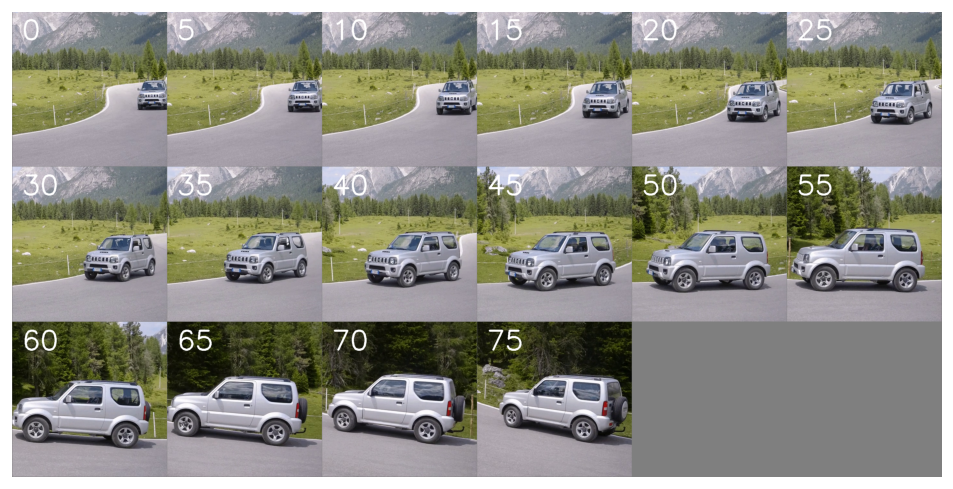

Keyframes are divided into 3 batches:
keyframe indexes [[0, 5, 10, 15, 20, 25, 30, 35], [40, 45, 50, 55, 60], [65, 70, 75]]


In [6]:
pipe, frescoProc, controlnet, detector, flow_model, sod_model = get_models(config)
device = pipe._execution_device
guidance_scale = 7.5
do_classifier_free_guidance = guidance_scale > 1
assert(do_classifier_free_guidance)
timesteps = pipe.scheduler.timesteps
cond_scale = [config['cond_scale']] * config['num_inference_steps']
dilate = Dilate(device=device)

base_prompt = config['prompt']
if 'Realistic' in config['sd_path'] or 'realistic' in config['sd_path']:
    a_prompt = ', RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3, '
    n_prompt = '(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation'
else:
    a_prompt = ', best quality, extremely detailed, '
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing finger, extra digit, fewer digits, cropped, worst quality, low quality'    

video_cap = cv2.VideoCapture(config['file_path'])
frame_num = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# you can set extra_prompts for individual keyframe
# for example, extra_prompts[38] = ', closed eyes' to specify the person frame38 closes the eyes
extra_prompts = [''] * frame_num

keys = get_keyframe_ind(config['file_path'], frame_num, config['mininterv'], config['maxinterv'])

os.makedirs(config['save_path'], exist_ok=True)
os.makedirs(config['save_path']+'keys', exist_ok=True)
os.makedirs(config['save_path']+'video', exist_ok=True)

sublists = [keys[i:i+config['batch_size']-2] for i in range(2, len(keys), config['batch_size']-2)]
sublists[0].insert(0, keys[0])
sublists[0].insert(1, keys[1])
if len(sublists) > 1 and len(sublists[-1]) < 3:
    add_num = 3 - len(sublists[-1])
    sublists[-1] = sublists[-2][-add_num:] + sublists[-1]
    sublists[-2] = sublists[-2][:-add_num]

imgs = []
for i in range(frame_num):
    success, frame = video_cap.read()
    if i in keys:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = resize_image(frame[:,:], 512)
        imgs += [cv2.putText(img.copy(), str(i), (32,92), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 6)]
img_ = torch.cat([numpy2tensor(img) for img in imgs], dim=0)
print('Select %d key frames'%(len(img_))) 
viz = torchvision.utils.make_grid(img_, int(len(img_)**0.7), 1)
visualize(viz.cpu(), 120)
print('Keyframes are divided into %d batches:\nkeyframe indexes'%(len(sublists)), sublists)    

### 4) run keyframe translation 
- run without FRESCO
- run with FRESCO

processing batch [1/3] with 8 frames
input of current batch:


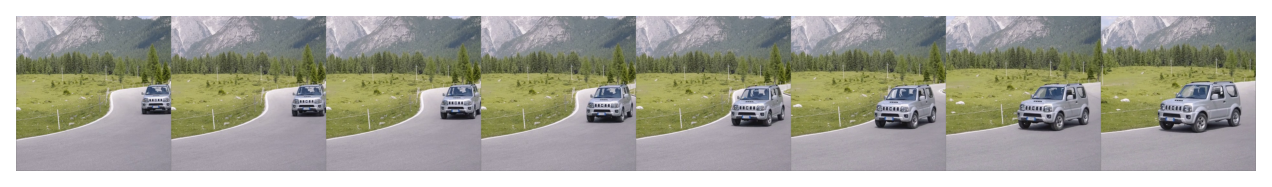

100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


results of current batch:


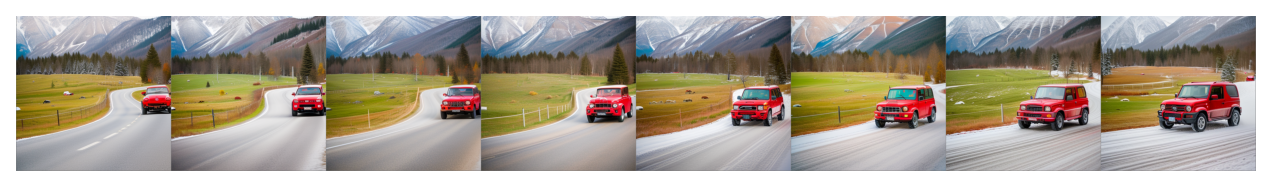

processing batch [2/3] with 5 frames
input of current batch:


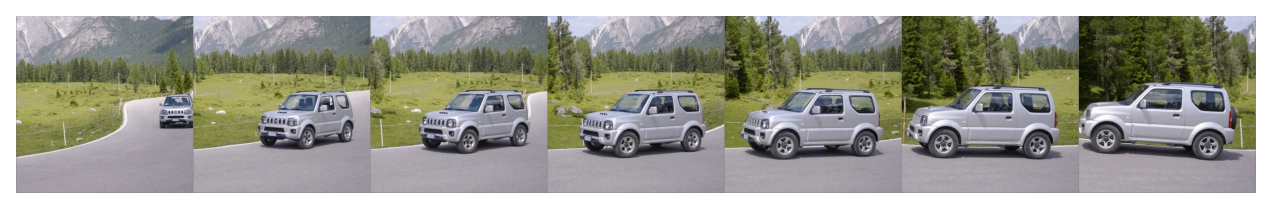

100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


results of current batch:


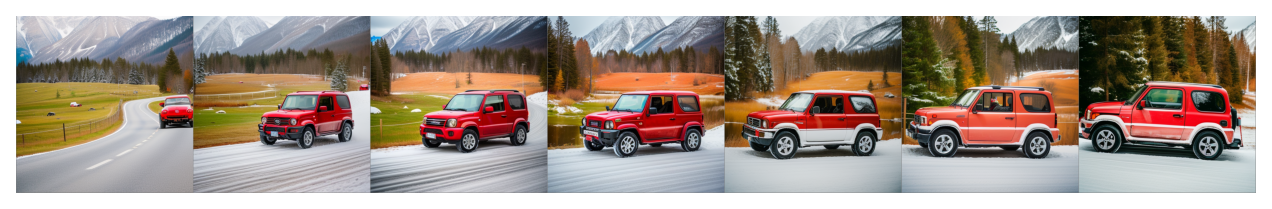

processing batch [3/3] with 3 frames
input of current batch:


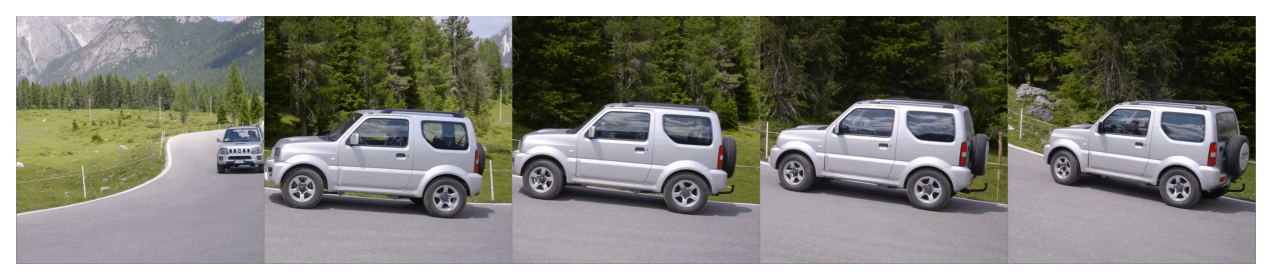

100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


results of current batch:


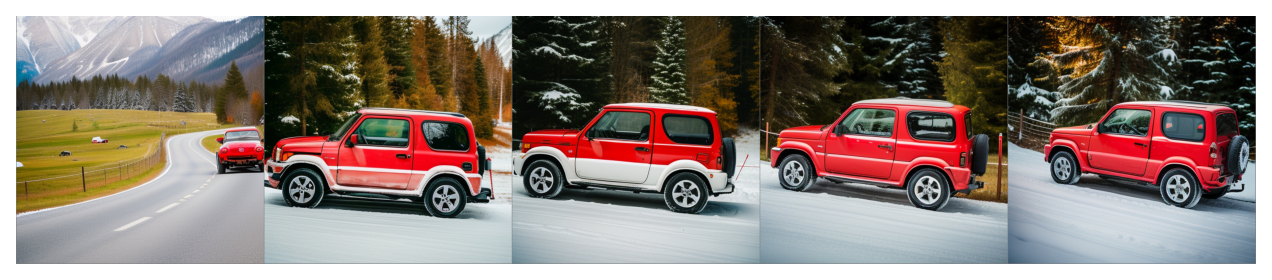

In [7]:
"""
run without FRESCO
"""
batch_ind = 0
propagation_mode = batch_ind > 0
imgs = []
record_latents = []
video_cap = cv2.VideoCapture(config['file_path'])
for i in range(frame_num):
    # prepare a batch of frame based on sublists
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = resize_image(frame, 512)
    H, W, C = img.shape
    Image.fromarray(img).save(os.path.join(config['save_path'], 'video/%04d.png'%(i)))
    if i not in sublists[batch_ind]:
        continue
        
    imgs += [img]
    if i != sublists[batch_ind][-1]:
        continue
    
    print('processing batch [%d/%d] with %d frames'%(batch_ind+1, len(sublists), len(sublists[batch_ind])))
    
    # prepare input
    batch_size = len(imgs)
    n_prompts = [n_prompt] * len(imgs)
    prompts = [base_prompt + a_prompt + extra_prompts[ind] for ind in sublists[batch_ind]]
    if propagation_mode: # restore the extra_prompts from previous batch
        assert len(imgs) == len(sublists[batch_ind]) + 2
        prompts = ref_prompt + prompts
    
    prompt_embeds = pipe._encode_prompt(
        prompts,
        device,
        1,
        do_classifier_free_guidance,
        n_prompts,
    ) 
        
    imgs_torch = torch.cat([numpy2tensor(img) for img in imgs], dim=0)

    print('input of current batch:')
    viz = torchvision.utils.make_grid(imgs_torch, len(imgs_torch), 1)
    visualize(viz.cpu(), 160)
    
    edges = torch.cat([numpy2tensor(apply_control(img, detector, config)[:, :, None]) for img in imgs], dim=0)
    edges = edges.repeat(1,3,1,1).cuda() * 0.5 + 0.5
    if do_classifier_free_guidance:
        edges = torch.cat([edges.to(pipe.unet.dtype)] * 2)
        
    # Turn on all FRESCO support
    frescoProc.controller.disable_controller()
    disable_FRESCO_opt(pipe)
    # run!
    latents = inference(pipe, controlnet, frescoProc, 
              imgs_torch, prompt_embeds, edges, timesteps,
              cond_scale, config['num_inference_steps'], config['num_warmup_steps'], 
              do_classifier_free_guidance, config['seed'], guidance_scale, config['use_controlnet'],         
              record_latents, propagation_mode,
              flows = None, occs = None, saliency=None, repeat_noise=True)
    
    with torch.no_grad():
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
        image = torch.clamp(image, -1 , 1)
        save_imgs = tensor2numpy(image)
        bias = 2 if propagation_mode else 0
        print('results of current batch:')
        viz = torchvision.utils.make_grid(image, len(image), 1)
        visualize(viz.cpu(), 160)
        
    batch_ind += 1
    # current batch uses the last frame of the previous batch as ref
    ref_prompt= [prompts[0], prompts[-1]]
    imgs = [imgs[0], imgs[-1]]
    propagation_mode = batch_ind > 0
    if batch_ind == len(sublists):
        gc.collect()
        torch.cuda.empty_cache()
        break    

processing batch [1/3] with 8 frames
input of current batch:


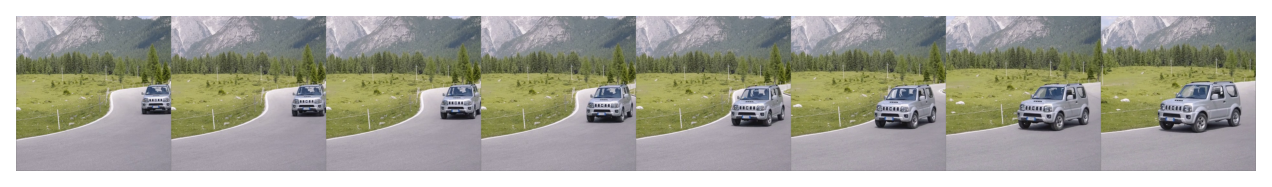

/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


results of current batch:


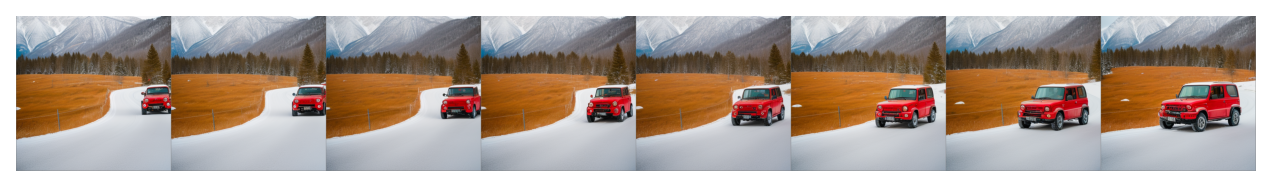

processing batch [2/3] with 5 frames
input of current batch:


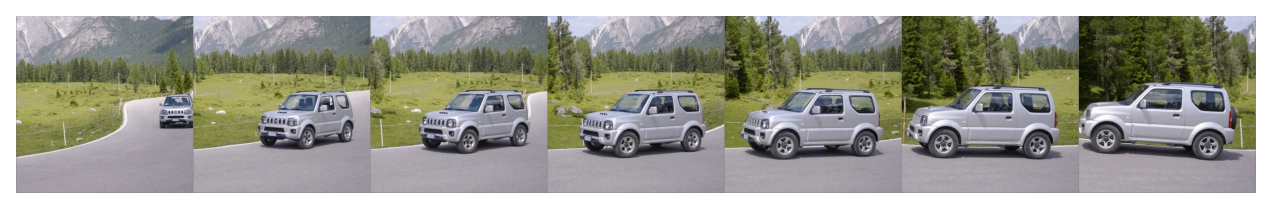

100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


results of current batch:


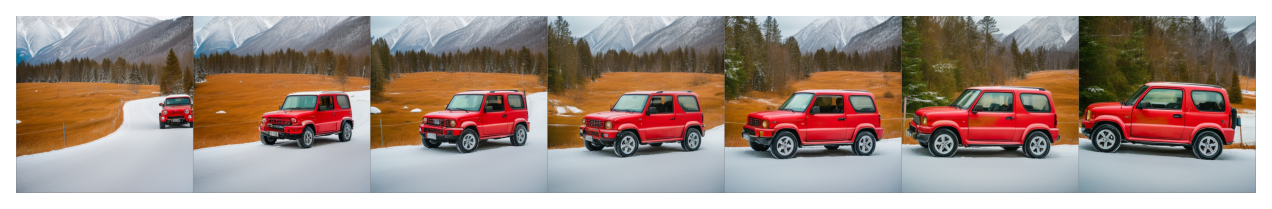

processing batch [3/3] with 3 frames
input of current batch:


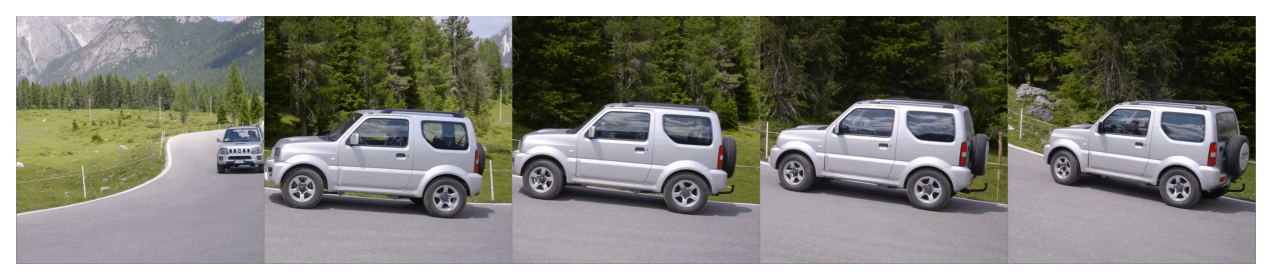

100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


results of current batch:


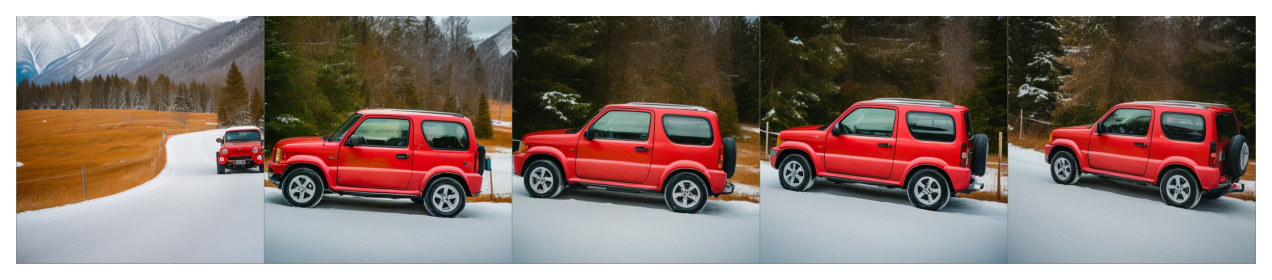

In [9]:
"""
run with FRESCO
"""
batch_ind = 0
propagation_mode = batch_ind > 0
imgs = []
record_latents = []
video_cap = cv2.VideoCapture(config['file_path'])
for i in range(frame_num):
    # prepare a batch of frame based on sublists
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = resize_image(frame, 512)
    H, W, C = img.shape
    Image.fromarray(img).save(os.path.join(config['save_path'], 'video/%04d.png'%(i)))
    if i not in sublists[batch_ind]:
        continue
        
    imgs += [img]
    if i != sublists[batch_ind][-1]:
        continue
    
    print('processing batch [%d/%d] with %d frames'%(batch_ind+1, len(sublists), len(sublists[batch_ind])))
    
    # prepare input
    batch_size = len(imgs)
    n_prompts = [n_prompt] * len(imgs)
    prompts = [base_prompt + a_prompt + extra_prompts[ind] for ind in sublists[batch_ind]]
    if propagation_mode: # restore the extra_prompts from previous batch
        assert len(imgs) == len(sublists[batch_ind]) + 2
        prompts = ref_prompt + prompts
    
    prompt_embeds = pipe._encode_prompt(
        prompts,
        device,
        1,
        do_classifier_free_guidance,
        n_prompts,
    ) 
        
    imgs_torch = torch.cat([numpy2tensor(img) for img in imgs], dim=0)

    print('input of current batch:')
    viz = torchvision.utils.make_grid(imgs_torch, len(imgs_torch), 1)
    visualize(viz.cpu(), 160)
    
    edges = torch.cat([numpy2tensor(apply_control(img, detector, config)[:, :, None]) for img in imgs], dim=0)
    edges = edges.repeat(1,3,1,1).cuda() * 0.5 + 0.5
    if do_classifier_free_guidance:
        edges = torch.cat([edges.to(pipe.unet.dtype)] * 2)
        
    if config['use_salinecy']:
        saliency = get_saliency(imgs, sod_model, dilate) 
    else:
        saliency = None
    
    # prepare parameters for inter-frame and intra-frame consistency
    flows, occs, attn_mask, interattn_paras = get_flow_and_interframe_paras(flow_model, imgs)
    correlation_matrix = get_intraframe_paras(pipe, imgs_torch, frescoProc, 
                        prompt_embeds, seed = config['seed'])

    '''
    Flexible settings for attention:
    * Turn off FRESCO-guided attention: frescoProc.controller.disable_controller() 
    Then you can turn on one specific attention submodule
    * Turn on Cross-frame attention: frescoProc.controller.enable_cfattn(attn_mask) 
    * Turn on Spatial-guided attention: frescoProc.controller.enable_intraattn() 
    * Turn on Temporal-guided attention: frescoProc.controller.enable_interattn(interattn_paras)

    Flexible settings for optimization:
    * Turn off Spatial-guided optimization: set optimize_temporal = False in apply_FRESCO_opt()
    * Turn off Temporal-guided optimization: set correlation_matrix = [] in apply_FRESCO_opt()
    * Turn off FRESCO-guided optimization: disable_FRESCO_opt(pipe)

    Flexible settings for background smoothing:
    * Turn off background smoothing: set saliency = None in apply_FRESCO_opt()
    '''    
    # Turn on all FRESCO support
    frescoProc.controller.enable_controller(interattn_paras=interattn_paras, attn_mask=attn_mask)
    apply_FRESCO_opt(pipe, steps = timesteps[:config['end_opt_step']],
                     flows = flows, occs = occs, correlation_matrix=correlation_matrix, 
                     saliency=saliency, optimize_temporal = True)
    
    gc.collect()
    torch.cuda.empty_cache()   
    
    # run!
    latents = inference(pipe, controlnet, frescoProc, 
              imgs_torch, prompt_embeds, edges, timesteps,
              cond_scale, config['num_inference_steps'], config['num_warmup_steps'], 
              do_classifier_free_guidance, config['seed'], guidance_scale, config['use_controlnet'],         
              record_latents, propagation_mode,
              flows = flows, occs = occs, saliency=saliency, repeat_noise=True)
    
    with torch.no_grad():
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
        image = torch.clamp(image, -1 , 1)
        save_imgs = tensor2numpy(image)
        bias = 2 if propagation_mode else 0
        for ind, num in enumerate(sublists[batch_ind]):
            Image.fromarray(save_imgs[ind+bias]).save(os.path.join(config['save_path'], 'keys/%04d.png'%(num)))
        print('results of current batch:')
        viz = torchvision.utils.make_grid(image, len(image), 1)
        visualize(viz.cpu(), 160)
        
    batch_ind += 1
    # current batch uses the last frame of the previous batch as ref
    ref_prompt= [prompts[0], prompts[-1]]
    imgs = [imgs[0], imgs[-1]]
    propagation_mode = batch_ind > 0
    if batch_ind == len(sublists):
        gc.collect()
        torch.cuda.empty_cache()
        break    

### 5) full video translation (optional)
- need to use ebsynth

In [10]:
if not config['run_ebsynth']:
    print('to translate full video with ebsynth, install ebsynth and run:')
else:
    print('translating full video with:')
    
video_cap = cv2.VideoCapture(config['file_path'])    
fps = int(video_cap.get(cv2.CAP_PROP_FPS))
o_video = os.path.join(config['save_path'], 'blend.mp4')
max_process = config['max_process']
save_path = config['save_path']
key_ind = io.StringIO()
for k in keys:
    print('%d'%(k), end=' ', file=key_ind)
cmd = (
    f'python video_blend.py {save_path} --key keys '
    f'--key_ind {key_ind.getvalue()} --output {o_video} --fps {fps} '
    f'--n_proc {max_process} -ps')

print('\n```')
print(cmd)
print('```')

if config['run_ebsynth']:
    os.system(cmd)

print('Done')    

translating full video with:

```
python video_blend.py ./output/example/ --key keys --key_ind 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75  --output ./output/example/blend.mp4 --fps 10 --n_proc 4 -ps
```


/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/yangs/miniconda3/envs/diffuser/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[att

ebsynth: 250.20923686027527
others: 11.88279914855957
others: 11.051883220672607
others: 9.8752121925354
others: 8.247264623641968
others: 8.729929208755493
others: 9.78529977798462
others: 13.975972175598145
others: 18.42204761505127
others: 11.400739192962646
others: 8.62275505065918
others: 7.620319128036499
others: 7.649445295333862
others: 7.817574977874756
others: 19.51055335998535
others: 18.241430282592773
Done
